In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE

%matplotlib inline

In [3]:
df = pd.read_csv('../data/vehicles.csv')
outback = df[df.model == 'outback'].copy()
del df
outback.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'image_url', 'state', 'lat', 'long', 'posting_date', 'VIN', 'size', 'type', 'description', 'drive', 'region', 'manufacturer', 'model'], inplace=True, axis=1)
outback.rename({'price':'USD'}, axis=1, inplace=True)
outback.rename({'odometer':'miles'}, axis=1, inplace=True)

#outback['km'] = outback['miles'] * 1.609
#outback['CAD'] = outback['USD'] * 1.26

## Filling missing values

In [4]:
outback.isna().sum()/len(outback)*100

USD              0.000000
year             0.000000
condition       49.525405
cylinders       40.089336
fuel             0.111669
miles           11.111111
title_status     0.279174
transmission     0.837521
paint_color     34.505863
dtype: float64

In [5]:
# Drops two vehicles with extreme prices, and two vehicles with no information other than miles
outback.drop([416548, 239974, 440910,248095] , inplace=True)
#outback.drop(440910, inplace=True)

# Drop vehicles with price at 0, since that's what we're trying to predict
outback.drop(outback[outback.USD == 0].index, inplace=True)

# Fills NAN values with average miles for each particular year
outback['miles'] = outback['miles'].fillna(outback.groupby('year')['miles'].transform('mean'))

outback.cylinders.fillna(value='unknown', inplace=True)


outback.title_status.fillna(value='clean', inplace=True)

# Cars with unknown transmissions tend to be newer; thus NANs are filled with automatic
outback.transmission.fillna(value='automatic', inplace=True)

outback.paint_color.fillna(value='other', inplace=True)

outback.condition.fillna(value='unknown', inplace=True)

outback.isna().sum()/len(outback)*100

USD             0.0
year            0.0
condition       0.0
cylinders       0.0
fuel            0.0
miles           0.0
title_status    0.0
transmission    0.0
paint_color     0.0
dtype: float64

# EDA

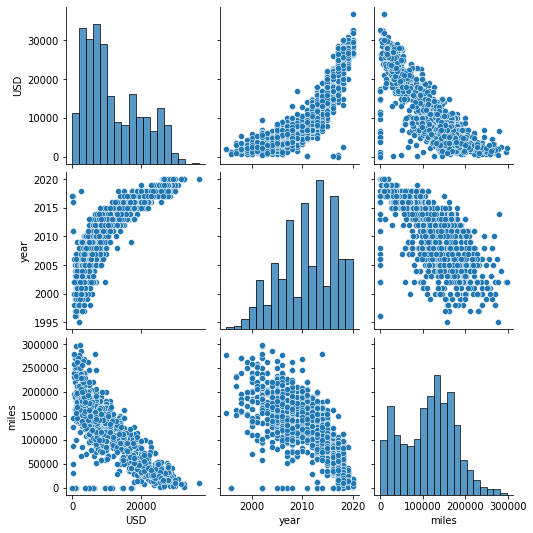

In [6]:
sns.pairplot(outback)

<AxesSubplot:xlabel='condition', ylabel='USD'>

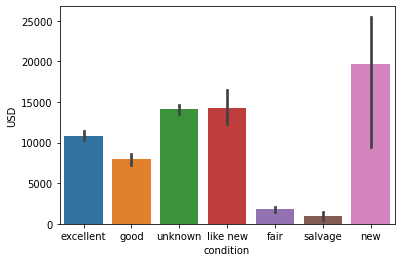

In [7]:
sns.barplot(x='condition', y='USD', data=outback)

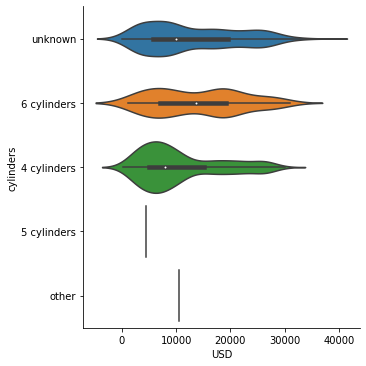

In [8]:
sns.catplot(y="cylinders", x="USD",kind = "violin", data=outback)

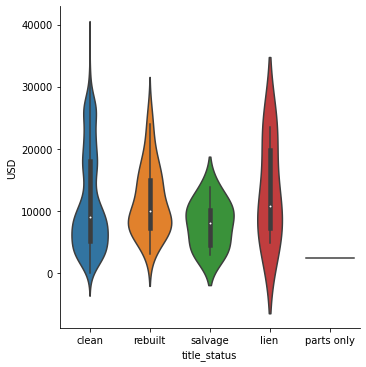

In [9]:
sns.catplot(x='title_status', y='USD', kind='violin', data=outback)

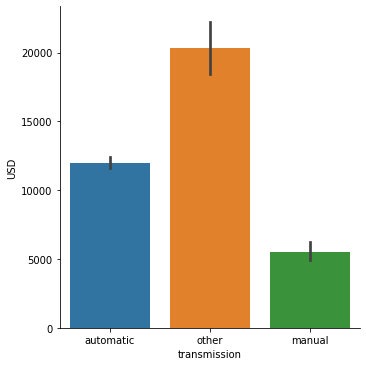

In [10]:
sns.catplot(x='transmission', y='USD', kind='bar', data=outback)

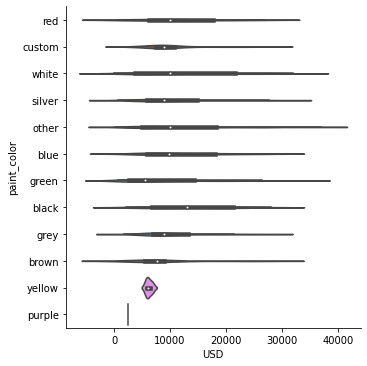

In [11]:
sns.catplot(y="paint_color", x="USD", kind="violin", data=outback)

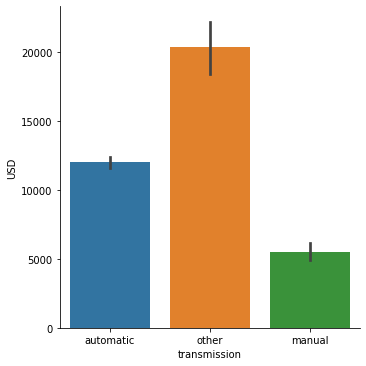

In [12]:
sns.catplot(x='transmission', y='USD', kind='bar', data=outback)

In [13]:
outback

,USD,year,condition,cylinders,fuel,miles,title_status,transmission,paint_color
57,8498,2011.0,excellent,unknown,gas,138247.0,clean,automatic,red
520,8980,2006.0,good,6 cylinders,gas,98791.0,clean,automatic,custom
2099,15977,2015.0,unknown,unknown,gas,101802.0,clean,automatic,white
2965,8950,2013.0,unknown,4 cylinders,gas,116000.0,rebuilt,automatic,silver
3369,24395,2017.0,unknown,unknown,gas,39100.0,clean,automatic,other
...,...,...,...,...,...,...,...,...,...
457541,6995,2011.0,like new,4 cylinders,gas,144067.0,clean,automatic,blue
457611,27998,2018.0,unknown,unknown,gas,17019.0,clean,automatic,other
457739,22999,2017.0,unknown,unknown,gas,36939.0,clean,automatic,blue
457755,26480,2017.0,unknown,4 cylinders,gas,16845.0,clean,automatic,silver


## Encoding categorical features

In [14]:
outback

,USD,year,condition,cylinders,fuel,miles,title_status,transmission,paint_color
57,8498,2011.0,excellent,unknown,gas,138247.0,clean,automatic,red
520,8980,2006.0,good,6 cylinders,gas,98791.0,clean,automatic,custom
2099,15977,2015.0,unknown,unknown,gas,101802.0,clean,automatic,white
2965,8950,2013.0,unknown,4 cylinders,gas,116000.0,rebuilt,automatic,silver
3369,24395,2017.0,unknown,unknown,gas,39100.0,clean,automatic,other
...,...,...,...,...,...,...,...,...,...
457541,6995,2011.0,like new,4 cylinders,gas,144067.0,clean,automatic,blue
457611,27998,2018.0,unknown,unknown,gas,17019.0,clean,automatic,other
457739,22999,2017.0,unknown,unknown,gas,36939.0,clean,automatic,blue
457755,26480,2017.0,unknown,4 cylinders,gas,16845.0,clean,automatic,silver


In [15]:
encoder = OrdinalEncoder()
ohe = OneHotEncoder(sparse=False)

In [16]:
ordinal_outback = outback[['condition', 'title_status']].copy()
categorical_outback = outback[['cylinders', 'fuel', 'transmission', 'paint_color']].copy()
numerical_outback = outback[['USD', 'year', 'miles']].copy()

In [17]:
ord_outback = pd.DataFrame(encoder.fit_transform(ordinal_outback), index=ordinal_outback.index, columns=ordinal_outback.columns)
cat_outback = pd.DataFrame(ohe.fit_transform(categorical_outback), index=categorical_outback.index, columns=ohe.get_feature_names())
clean_outback = pd.concat([numerical_outback, ord_outback, cat_outback], axis=1)

In [18]:
clean_outback

,USD,year,miles,condition,title_status,x0_4 cylinders,x0_5 cylinders,x0_6 cylinders,x0_other,x0_unknown,...,x3_brown,x3_custom,x3_green,x3_grey,x3_other,x3_purple,x3_red,x3_silver,x3_white,x3_yellow
57,8498,2011.0,138247.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
520,8980,2006.0,98791.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2099,15977,2015.0,101802.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2965,8950,2013.0,116000.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3369,24395,2017.0,39100.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457541,6995,2011.0,144067.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457611,27998,2018.0,17019.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
457739,22999,2017.0,36939.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457755,26480,2017.0,16845.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Train/Test Split

In [19]:
y = clean_outback.USD
X = clean_outback.drop('USD', axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1380, 27) (1380,)
(345, 27) (345,)


# Testing models

## Random Forest


In [22]:
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


In [23]:
print('MAE:', round(MAE(y_test, y_pred), 2))
print('MSE:', round(MSE(y_test, y_pred), 2))
print('Score:', regressor.score(X_test, y_test)*100)

MAE: 1368.7
MSE: 6678187.95
Score: 89.67711464913147


In [24]:
outback

,USD,year,condition,cylinders,fuel,miles,title_status,transmission,paint_color
57,8498,2011.0,excellent,unknown,gas,138247.0,clean,automatic,red
520,8980,2006.0,good,6 cylinders,gas,98791.0,clean,automatic,custom
2099,15977,2015.0,unknown,unknown,gas,101802.0,clean,automatic,white
2965,8950,2013.0,unknown,4 cylinders,gas,116000.0,rebuilt,automatic,silver
3369,24395,2017.0,unknown,unknown,gas,39100.0,clean,automatic,other
...,...,...,...,...,...,...,...,...,...
457541,6995,2011.0,like new,4 cylinders,gas,144067.0,clean,automatic,blue
457611,27998,2018.0,unknown,unknown,gas,17019.0,clean,automatic,other
457739,22999,2017.0,unknown,unknown,gas,36939.0,clean,automatic,blue
457755,26480,2017.0,unknown,4 cylinders,gas,16845.0,clean,automatic,silver


## Making new predictions

In [25]:
new_data = [{'year': 2001,'condition': 'good', 'cylinders': '6 cylinders', 'fuel':'gas', 'miles': 200000.0, 'title_status':'clean', 'transmission':'automatic', 'paint_color':'black'}]
new_data = pd.DataFrame(new_data)

In [26]:
ordinal = ['condition', 'title_status'] # Ordinal Encoder
categorical = ['cylinders', 'fuel', 'transmission', 'paint_color'] # OHE
numerical = ['year', 'miles']

In [27]:
encoder.transform(new_data[ordinal])

array([[2., 0.]])

In [28]:
ord_ = pd.DataFrame(encoder.transform(new_data[ordinal]), index=new_data[ordinal].index, columns=new_data[ordinal].columns)
cat_ = pd.DataFrame(ohe.transform(new_data[categorical]), index=new_data[categorical].index, columns=ohe.get_feature_names())
clean_ = pd.concat([new_data[numerical], ord_, cat_], axis=1)

In [29]:
clean_

,year,miles,condition,title_status,x0_4 cylinders,x0_5 cylinders,x0_6 cylinders,x0_other,x0_unknown,x1_diesel,...,x3_brown,x3_custom,x3_green,x3_grey,x3_other,x3_purple,x3_red,x3_silver,x3_white,x3_yellow
0,2001,200000.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
regressor.predict(clean_)

array([2661.25])

## Same as above, but with a pipeline

In [31]:
ordinal = ['condition', 'title_status'] # Ordinal Encoder
categorical = ['cylinders', 'fuel', 'transmission', 'paint_color'] # OHE
numerical = ['year', 'miles']

In [32]:
y = outback.USD
X = outback.drop('USD', axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [34]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [35]:
ct = ColumnTransformer(transformers = [
                            ('ordinalEncoder', encoder, ordinal),
                            ('oneHotEncoder', ohe, categorical )
                            ],
                        remainder='passthrough')

In [36]:
X_train_transformed = ct.fit_transform(X_train)

In [37]:
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(X_train_transformed, y_train.values)
y_pred = regressor.predict(ct.transform(X_test))

In [38]:
print('MAE:', round(MAE(y_test, y_pred), 2))
print('MSE:', round(MSE(y_test, y_pred), 2))
print('Score:', regressor.score(ct.transform(X_test), y_test)*100)

MAE: 1166.72
MSE: 3342576.65
Score: 94.57931409732055


## Using Cross Val Score

In [39]:
cross_val_score(regressor, X_train_transformed, y_train.values, scoring='neg_mean_absolute_error', cv=3).mean()

-1338.975968537228

## Tuning with GridSearchCV

In [49]:
regressor = RandomForestRegressor(n_estimators=20)

In [50]:
pipe = Pipeline(steps=[('preprocess', ct),
                        ('model', regressor)])

In [51]:
# pipe.fit(X, y)

In [52]:
#y_pred = pipe.predict(X_test)
#print('MAE:', round(MAE(y_test, y_pred), 2))
# print('MSE:', round(MSE(y_test, y_pred), 2))
# print('Score:', regressor.score(ct.transform(X_test), y_test)*100)

In [53]:
#pipe.get_params().keys()

In [54]:
parameters = {
  'model__n_estimators':list(range(5,110,5)),
  'model__criterion' : ['mse', 'mae'],
  'model__max_features': ['auto', 'sqrt', 'log2'],
  'model__min_samples_split': [2,3,4,5]
  }

In [55]:
gs = GridSearchCV(estimator=pipe, param_grid=parameters, verbose=2)
 

In [49]:
gs.fit(X, y)

tal time=   0.7s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=55; total time=   0.6s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.8s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.7s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.8s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.7s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=60; total time=   0.7s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, model__n_estimators=65; total time=   1.0s
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=4, mo

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalEncoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['condition',
                                                                          'title_status']),
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                          

In [51]:
import pickle

In [52]:
pickle.dump(gs.best_estimator_, open('model.pkl', 'wb'))

In [124]:
#print('MAE:', round(MAE(y_test, gs.best_estimator_.predict(X_test)), 2))
#print('MSE:', round(MSE(y_test, gs.best_estimator_.predict(X_test)), 2))


MAE: 1055.62
MSE: 2295116.23


<AxesSubplot:xlabel='miles'>

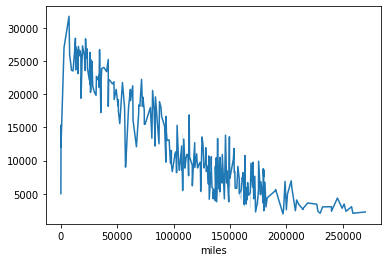

In [128]:
sns.lineplot(x=X_test['miles'], y=gs.best_estimator_.predict(X_test))

In [145]:
X_test[:1]

,year,condition,cylinders,fuel,miles,title_status,transmission,paint_color
210652,2015.0,excellent,4 cylinders,gas,74000.0,clean,automatic,other


In [1]:
import pickle





## Scaling target variable

In [42]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()

yhat = scaler.fit_transform(y_train.values.reshape(-1,1))

In [40]:
y

57         8498
520        8980
2099      15977
2965       8950
3369      24395
          ...  
457541     6995
457611    27998
457739    22999
457755    26480
457849    29995
Name: USD, Length: 1725, dtype: int64

In [59]:
yhat

array([[-0.60630157],
       [ 1.01171595],
       [ 0.87632064],
       ...,
       [-0.95469225],
       [ 1.38551661],
       [-0.73110939]])

In [56]:
gs_scale = GridSearchCV(estimator=pipe, param_grid=parameters, verbose=2)

In [60]:
gs_scale.fit(X_train,yhat)

ing ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=5, model__n_estimators=60; total time=   0.6s
C:\Users\adrav\Desktop\projects\Math\.venv\math\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[CV] END model__criterion=mae, model__max_features=log2, model__min_samples_split=5, model__n_estimators=65; total time=   0.6s
C:\Users\adrav\Desktop\projects\Math\.venv\math\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[CV] END model__criterion=mae, model__max_features=log2, model

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalEncoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['condition',
                                                                          'title_status']),
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                          

In [61]:
gs_scale.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalEncoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['condition',
                                                   'title_status']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['cylinders', 'fuel',
                                                   'transmission',
                                                   'paint_color'])])),
                ('model',
                 RandomForestRegressor(criterion='ma

In [70]:
ypred_scale = gs_scale.predict(X_test)
print('MAE:', round(MAE(y_test, scaler.inverse_transform(ypred_scale)), 2))
print('MSE:', round(MSE(y_test, scaler.inverse_transform(ypred_scale)), 2))

MAE: 1159.81
MSE: 3253800.0


In [69]:
scaler.inverse_transform(ypred_scale)

array([14682.71, 20875.15,  3413.22,  4906.08, 18951.29,  4186.28,
       23850.66,  4584.89,  6584.49, 16326.6 , 27026.53,  2942.09,
        6845.98, 16988.  , 17992.28,  7116.81,  3786.87, 23358.86,
        4596.69,  3369.78,  7876.04,  7018.35,  4584.89,  9372.24,
        5666.11,  8221.85,  9021.79, 30639.35,  8588.67, 21469.  ,
        7593.9 ,  3978.37,  4727.75, 21050.01,  2528.9 ,  3500.  ,
       25834.08,  4953.59,  8568.19,  2195.64,  8379.61,  7783.09,
        3265.78, 24359.51,  3528.49, 22403.4 , 17064.47,  9435.01,
       13618.96, 10079.15, 25948.49,  2090.23,  7872.85, 17676.44,
       21443.12, 15059.82, 11687.59, 19536.49,  6261.06, 22150.69,
       16841.53, 11030.62, 25826.71, 10053.09, 13272.18, 23480.69,
        7765.44,  2681.42,  8469.16,  3837.82, 26983.66,  2207.29,
       16686.66,  2628.09, 25899.7 ,  6778.97,  9430.24, 21465.87,
       13274.57,  6246.04,  3104.95, 10824.72, 10995.  ,  7921.36,
        6886.64,  2974.  , 16891.2 , 18291.97, 14449.23,  4930